In [12]:
import pandas as pd
from sklearn.experimental import enable_iterative_imputer 
from sklearn.impute import IterativeImputer
import numpy as np  # For numerical operations
import matplotlib.pyplot as plt  # For creating static, animated, and interactive visualizations
import seaborn as sns  # For statistical data visualization
import scipy.stats as stats  # For statistical analysis

file_path = 'bustabit.csv'
df = pd.read_csv(file_path)

# Display the first few rows of the dataset to inspect its structure
df.head()
df.describe()

,Id,GameID,Bet,CashedOut,Bonus,Profit,BustedAt
count,5.000000e+04,5.000000e+04,50000.000000,28734.000000,28734.000000,2.873400e+04,50000.000000
mean,1.353050e+07,3.363443e+06,2935.250980,1.686600,1.380313,1.534772e+03,16.790000
std,7.768258e+06,4.160723e+04,30651.925762,2.185089,1.628110,2.000082e+04,1172.876203
min,8.540000e+02,3.294811e+06,1.000000,1.000000,0.000000,0.000000e+00,0.000000
25%,6.829364e+06,3.325926e+06,4.000000,1.070000,0.000000,8.500000e-01,1.310000
50%,1.357023e+07,3.362088e+06,20.000000,1.210000,1.000000,5.330000e+00,1.950000
75%,2.023714e+07,3.400994e+06,180.000000,1.570000,2.470000,6.303250e+01,3.852500
max,2.697852e+07,3.436562e+06,1000000.000000,126.000000,12.140000,1.175993e+06,251025.130000


In [14]:
#Cleaning The Data
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

# Converting 'PlayDate' to datetime
df['PlayDate'] = pd.to_datetime(df['PlayDate'])

# Remove duplicates
df_cleaned = df.drop_duplicates()

# Apply multiple imputation for missing values in 'CashedOut', 'Bonus', and 'Profit'
imputer = IterativeImputer(max_iter=10, random_state=0)
imputed_columns = ['CashedOut', 'Bonus', 'Profit']

df_cleaned[imputed_columns] = imputer.fit_transform(df_cleaned[imputed_columns])

# Verifying Changes
missing_values_after_imputation = df_cleaned.isnull().sum()
data_types_after_imputation = df_cleaned.dtypes

missing_values_after_imputation, data_types_after_imputation


(Id           0
 GameID       0
 Username     0
 Bet          0
 CashedOut    0
 Bonus        0
 Profit       0
 BustedAt     0
 PlayDate     0
 dtype: int64,
 Id                         int64
 GameID                     int64
 Username                  object
 Bet                        int64
 CashedOut                float64
 Bonus                    float64
 Profit                   float64
 BustedAt                 float64
 PlayDate     datetime64[ns, UTC]
 dtype: object)

In [ ]:
# Step 1: Create the 'NetProfit' column
df_cleaned['NetProfit'] = (df_cleaned['Bet'] * df_cleaned['CashedOut']) + (df_cleaned['Bet'] * df_cleaned['Bonus']) - df_cleaned['Bet']

# Step 2: Calculate CLV metrics per player (total bets, total profit, etc.)
player_clv = df_cleaned.groupby('Username').agg(
    total_bet=('Bet', 'sum'),
    total_profit=('NetProfit', 'sum'),
    total_games=('GameID', 'count'),
    avg_bet=('Bet', 'mean'),
    avg_profit=('NetProfit', 'mean')
).reset_index()

# Display the first few rows of the CLV data
player_clv.head()


In [16]:
# Calculating Net Profit and Customer Lifetime Value (CLV)

# Creating the 'NetProfit' column
df_cleaned['NetProfit'] = (df_cleaned['Bet'] * df_cleaned['CashedOut']) + (df_cleaned['Bet'] * df_cleaned['Bonus']) - df_cleaned['Bet']

# Calculating CLV metrics per player (total bets, total profit, etc.)
player_clv = df_cleaned.groupby('Username').agg(
    total_bet=('Bet', 'sum'),
    total_profit=('NetProfit', 'sum'),
    total_games=('GameID', 'count'),
    avg_bet=('Bet', 'mean'),
    avg_profit=('NetProfit', 'mean')
).reset_index()

player_clv.head()


,Username,total_bet,total_profit,total_games,avg_bet,avg_profit
0,----------------,31,63.695307,3,10.333333,21.231769
1,--dilib--,1686,4027.595718,8,210.750000,503.449465
2,-31337-,130,135.180238,4,32.500000,33.795059
3,-Nothing-,20987,40192.596249,65,322.876923,618.347635
4,-Tachyon,5124,12419.624089,5,1024.800000,2483.924818


In [18]:
# Player Segmentation

# Segmentation based on total profit
high_value_threshold = player_clv['total_profit'].quantile(0.75)
low_value_threshold = player_clv['total_profit'].quantile(0.25)

# Creating a new column for segmentation
player_clv['Segment'] = pd.cut(player_clv['total_profit'],
                                bins=[-float('inf'), low_value_threshold, high_value_threshold, float('inf')],
                                labels=['Low-Value', 'Medium-Value', 'High-Value'])

player_clv.head()


,Username,total_bet,total_profit,total_games,avg_bet,avg_profit,Segment
0,----------------,31,63.695307,3,10.333333,21.231769,Low-Value
1,--dilib--,1686,4027.595718,8,210.750000,503.449465,Medium-Value
2,-31337-,130,135.180238,4,32.500000,33.795059,Medium-Value
3,-Nothing-,20987,40192.596249,65,322.876923,618.347635,High-Value
4,-Tachyon,5124,12419.624089,5,1024.800000,2483.924818,High-Value


In [28]:
# Dealing with Outliers

# Calculate IQR for Total Bet and Total Profit
Q1_bet = player_clv['total_bet'].quantile(0.25)
Q3_bet = player_clv['total_bet'].quantile(0.75)
IQR_bet = Q3_bet - Q1_bet

Q1_profit = player_clv['total_profit'].quantile(0.25)
Q3_profit = player_clv['total_profit'].quantile(0.75)
IQR_profit = Q3_profit - Q1_profit

# Define the lower and upper bounds for Total Bet and Total Profit
lower_bound_bet = Q1_bet - 1.5 * IQR_bet
upper_bound_bet = Q3_bet + 1.5 * IQR_bet

lower_bound_profit = Q1_profit - 1.5 * IQR_profit
upper_bound_profit = Q3_profit + 1.5 * IQR_profit

# Remove or cap outliers for Total Bet and Total Profit
# Remove rows with outliers
df_no_outliers = player_clv[
    (player_clv['total_bet'] >= lower_bound_bet) & (player_clv['total_bet'] <= upper_bound_bet) &
    (player_clv['total_profit'] >= lower_bound_profit) & (player_clv['total_profit'] <= upper_bound_profit)
]

# Alternatively, you can cap outliers instead of removing them by setting values outside bounds to the nearest bound
df_capped = player_clv.copy()
df_capped['total_bet'] = df_capped['total_bet'].clip(lower=lower_bound_bet, upper=upper_bound_bet)
df_capped['total_profit'] = df_capped['total_profit'].clip(lower=lower_bound_profit, upper=upper_bound_profit)

df_no_outliers.head(), df_capped.head()

(           Username  total_bet  total_profit  total_games      avg_bet  \
 0  ----------------         31     63.695307            3    10.333333   
 1         --dilib--       1686   4027.595718            8   210.750000   
 2           -31337-        130    135.180238            4    32.500000   
 4          -Tachyon       5124  12419.624089            5  1024.800000   
 5               -Y-         32     66.141229            2    16.000000   
 
     avg_profit       Segment  
 0    21.231769     Low-Value  
 1   503.449465  Medium-Value  
 2    33.795059  Medium-Value  
 4  2483.924818    High-Value  
 5    33.070615     Low-Value  ,
            Username  total_bet  total_profit  total_games      avg_bet  \
 0  ----------------         31     63.695307            3    10.333333   
 1         --dilib--       1686   4027.595718            8   210.750000   
 2           -31337-        130    135.180238            4    32.500000   
 3         -Nothing-      13415  22380.981299          

In [30]:
# Segmentation based on total profit
high_value_threshold_capped = df_capped['total_profit'].quantile(0.75)
low_value_threshold_capped = df_capped['total_profit'].quantile(0.25)

# Create a new column for segmentation based on capped data
df_capped['Segment'] = pd.cut(df_capped['total_profit'],
                               bins=[-float('inf'), low_value_threshold_capped, high_value_threshold_capped, float('inf')],
                               labels=['Low-Value', 'Medium-Value', 'High-Value'])

# Display the first few rows with updated segmentation
print(df_capped.head())


           Username  total_bet  total_profit  total_games      avg_bet  \
0  ----------------         31     63.695307            3    10.333333   
1         --dilib--       1686   4027.595718            8   210.750000   
2           -31337-        130    135.180238            4    32.500000   
3         -Nothing-      13415  22380.981299           65   322.876923   
4          -Tachyon       5124  12419.624089            5  1024.800000   

    avg_profit       Segment  
0    21.231769     Low-Value  
1   503.449465  Medium-Value  
2    33.795059  Medium-Value  
3   618.347635    High-Value  
4  2483.924818    High-Value  


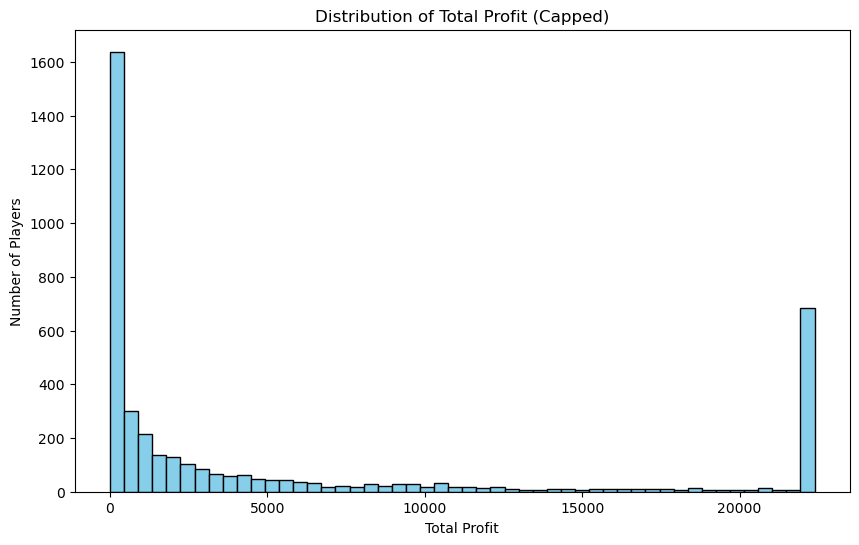

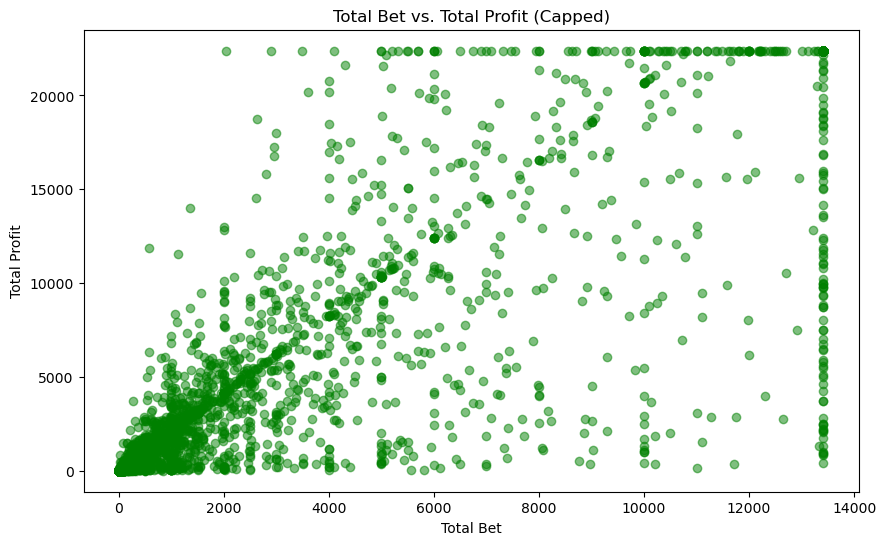

<Figure size 1000x600 with 0 Axes>

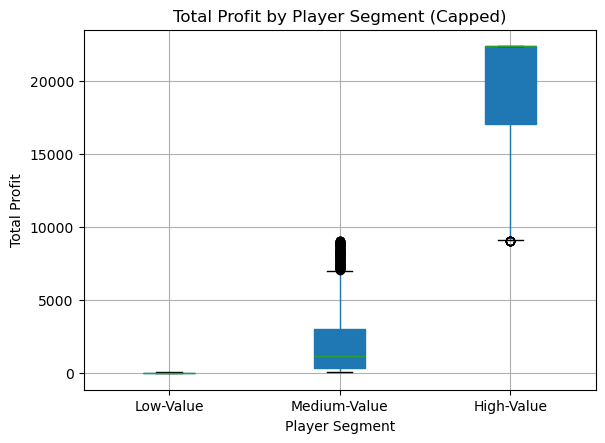

In [40]:
# EDA 

# Histogram for Total Profit (after capping outliers)
plt.figure(figsize=(10, 6))
plt.hist(df_capped['total_profit'], bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Total Profit (Capped)')
plt.xlabel('Total Profit')
plt.ylabel('Number of Players')
plt.show()

# Scatter plot for Total Bet vs. Total Profit (after capping outliers)
plt.figure(figsize=(10, 6))
plt.scatter(df_capped['total_bet'], df_capped['total_profit'], alpha=0.5, color='green')
plt.title('Total Bet vs. Total Profit (Capped)')
plt.xlabel('Total Bet')
plt.ylabel('Total Profit')
plt.show()

# Boxplot for Player Segments (Total Profit after capping)
plt.figure(figsize=(10, 6))
df_capped.boxplot(column='total_profit', by='Segment', patch_artist=True)
plt.title('Total Profit by Player Segment (Capped)')
plt.suptitle('')
plt.xlabel('Player Segment')
plt.ylabel('Total Profit')
plt.show()

In [34]:
# Predictive Modeling (CLV Prediction)

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.preprocessing import LabelEncoder

# Preparing the data for modeling

# Convert categorical features (Segment) to numerical using Label Encoding
label_encoder = LabelEncoder()
df_capped['Segment_encoded'] = label_encoder.fit_transform(df_capped['Segment'])

# Features (X) and Target (y)
X = df_capped[['total_bet', 'total_games', 'avg_bet', 'avg_profit', 'Segment_encoded']]
y = df_capped['total_profit']  # Target: Total Profit

# Spliting data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Training a Linear Regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error (MAE): {mae}')
print(f'R-squared: {r2}')


Mean Absolute Error (MAE): 2008.7289520934476
R-squared: 0.8844884776511968


In [36]:
# Code for Player Retention Prediction:

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

# Convert categorical features (Segment) to numerical using Label Encoding
label_encoder = LabelEncoder()
df_capped['Segment_encoded'] = label_encoder.fit_transform(df_capped['Segment'])

# Create a retention target variable (1 if games played > 5, else 0)
df_capped['retained'] = (df_capped['total_games'] > 5).astype(int)

# Features (X) and Target (y)
X_retention = df_capped[['total_bet', 'total_games', 'avg_bet', 'avg_profit', 'Segment_encoded']]
y_retention = df_capped['retained']  # Target: Retention (binary)

# Splitting data into training and testing sets (80/20 split)
X_train, X_test, y_train, y_test = train_test_split(X_retention, y_retention, test_size=0.2, random_state=42)

# Train a Logistic Regression model
log_model = LogisticRegression()
log_model.fit(X_train, y_train)

# Make predictions
y_pred = log_model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Display results
print(f'Accuracy: {accuracy}')
print('Classification Report:')
print(report)


Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       521
           1       1.00      1.00      1.00       309

    accuracy                           1.00       830
   macro avg       1.00      1.00      1.00       830
weighted avg       1.00      1.00      1.00       830



/opt/anaconda3/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [38]:
# Deep Dive into Player Behaviour
# Time between Bets

# Convert PlayDate to datetime if not already
df_cleaned['PlayDate'] = pd.to_datetime(df_cleaned['PlayDate'])

# Sort data by Username and PlayDate
df_cleaned = df_cleaned.sort_values(by=['Username', 'PlayDate'])

# Calculate time between consecutive bets (in seconds)
df_cleaned['time_between_bets'] = df_cleaned.groupby('Username')['PlayDate'].diff().dt.total_seconds()

df_cleaned[['Username', 'PlayDate', 'time_between_bets']].head()


,Username,PlayDate,time_between_bets
25389,----------------,2016-11-03 06:14:27+00:00,NaN
37757,----------------,2016-11-03 15:05:40+00:00,31873.0
47386,----------------,2016-11-03 20:26:24+00:00,19244.0
19471,--dilib--,2016-11-01 22:57:26+00:00,NaN
33955,--dilib--,2016-11-02 00:56:16+00:00,7130.0


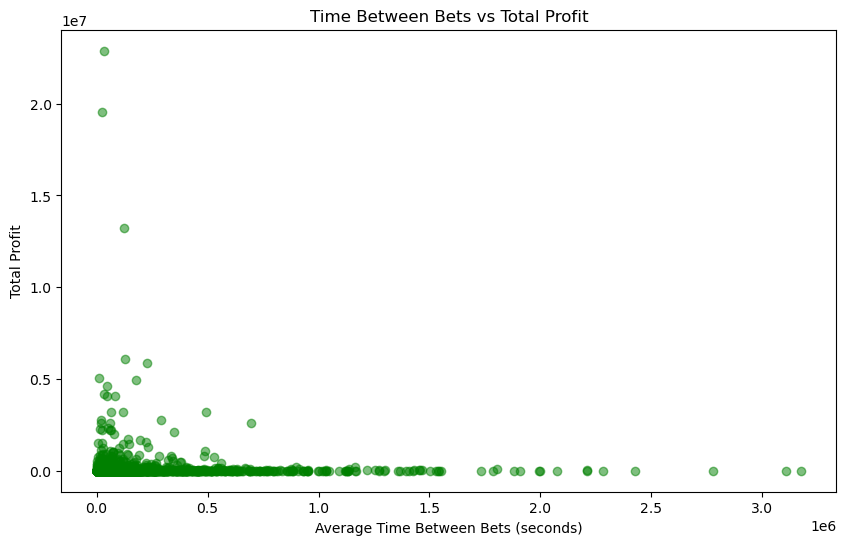

In [44]:
# Calculatng Player Lifetime Value (CLV) metrics again
player_clv = df_cleaned.groupby('Username').agg(
    total_bet=('Bet', 'sum'),
    total_profit=('NetProfit', 'sum'),
    total_games=('GameID', 'count'),
    avg_bet=('Bet', 'mean'),
    avg_profit=('NetProfit', 'mean')
).reset_index()

# Calculate average time between bets per player

average_time_between_bets = df_cleaned.groupby('Username')['time_between_bets'].mean().reset_index()

# Plotting the scatter plot for Time Between Bets vs Total Profit
plt.figure(figsize=(10, 6))
plt.scatter(average_time_between_bets['time_between_bets'], player_clv['total_profit'], alpha=0.5, color='green')
plt.title('Time Between Bets vs Total Profit')
plt.xlabel('Average Time Between Bets (seconds)')
plt.ylabel('Total Profit')
plt.show()


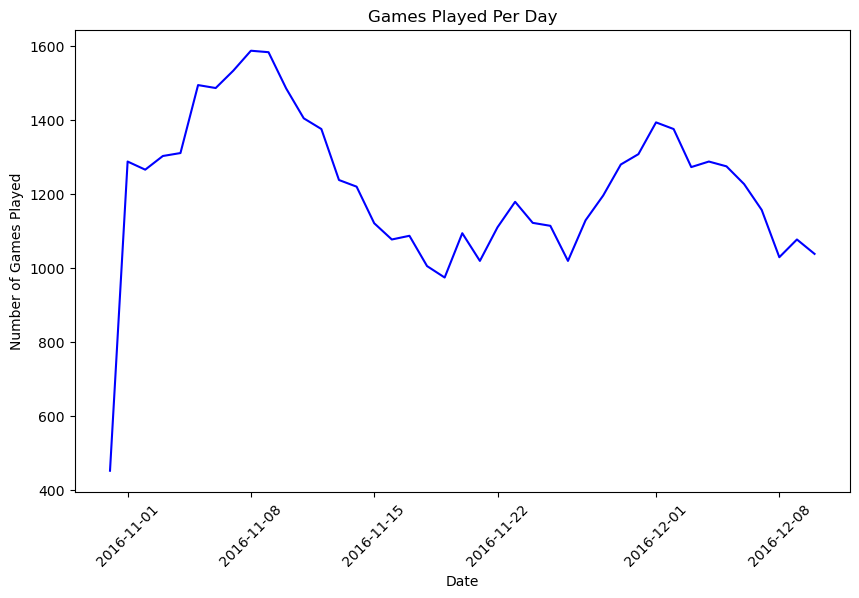

In [46]:
# Game Participation Trends

# Grouping by PlayDate to track the number of games played each day
df_cleaned['date'] = df_cleaned['PlayDate'].dt.date  # Extract the date part from PlayDate
games_per_day = df_cleaned.groupby('date').size().reset_index(name='games_played')

# Plotting the number of games played per day over time
plt.figure(figsize=(10, 6))
plt.plot(games_per_day['date'], games_per_day['games_played'], color='blue')
plt.title('Games Played Per Day')
plt.xlabel('Date')
plt.ylabel('Number of Games Played')
plt.xticks(rotation=45)
plt.show()


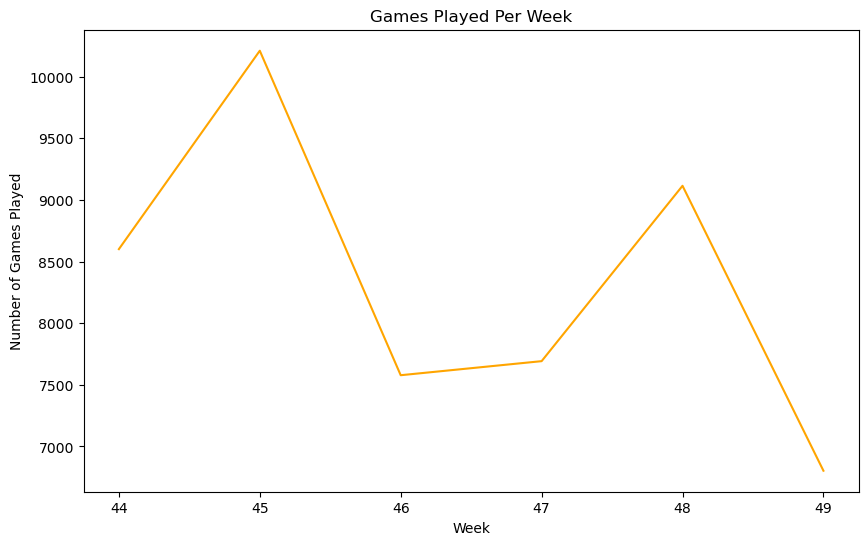

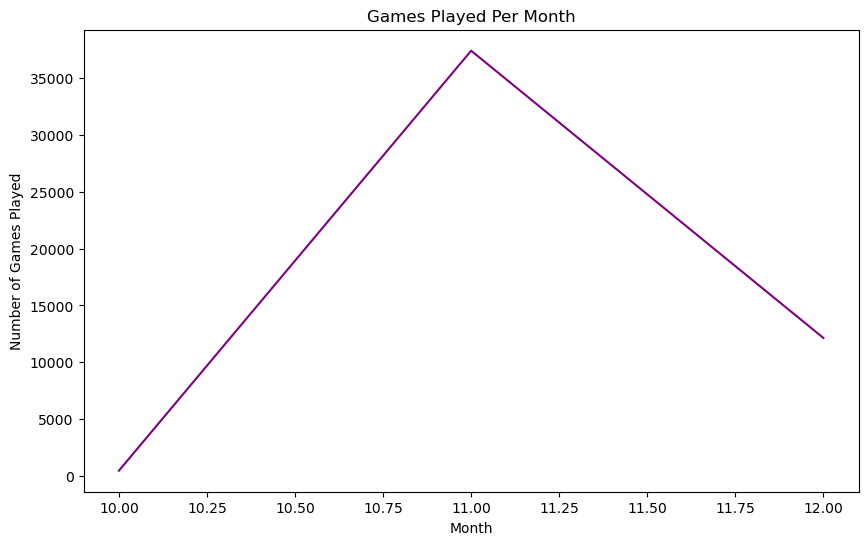

In [48]:
# Weekly and Monthly Trends

# Grouping by Week to track the number of games played each week
df_cleaned['week'] = df_cleaned['PlayDate'].dt.isocalendar().week
games_per_week = df_cleaned.groupby('week').size().reset_index(name='games_played_weekly')

# Ploting the number of games played per week over time
plt.figure(figsize=(10, 6))
plt.plot(games_per_week['week'], games_per_week['games_played_weekly'], color='orange')
plt.title('Games Played Per Week')
plt.xlabel('Week')
plt.ylabel('Number of Games Played')
plt.show()

# Grouping by Month to track the number of games played each month
df_cleaned['month'] = df_cleaned['PlayDate'].dt.month
games_per_month = df_cleaned.groupby('month').size().reset_index(name='games_played_monthly')

# Plotting the number of games played per month over time
plt.figure(figsize=(10, 6))
plt.plot(games_per_month['month'], games_per_month['games_played_monthly'], color='purple')
plt.title('Games Played Per Month')
plt.xlabel('Month')
plt.ylabel('Number of Games Played')
plt.show()


In [50]:
# Calculating the first bet date for each player
df_cleaned['first_bet_date'] = df_cleaned.groupby('Username')['PlayDate'].transform('min')

# Calculating the number of days since the first bet for each entry
df_cleaned['days_since_first_bet'] = (df_cleaned['PlayDate'] - df_cleaned['first_bet_date']).dt.days

# Defining retention - players who return within a certain time (e.g., 30 days)
df_cleaned['retained'] = df_cleaned['days_since_first_bet'] <= 30  # Players who return within 30 days

# Calculating retention rate for players who returned within 30 days
retention_rate = df_cleaned.groupby('Username')['retained'].max().mean()

print(f"30-Day Retention Rate: {retention_rate:.2f}")


30-Day Retention Rate: 1.00


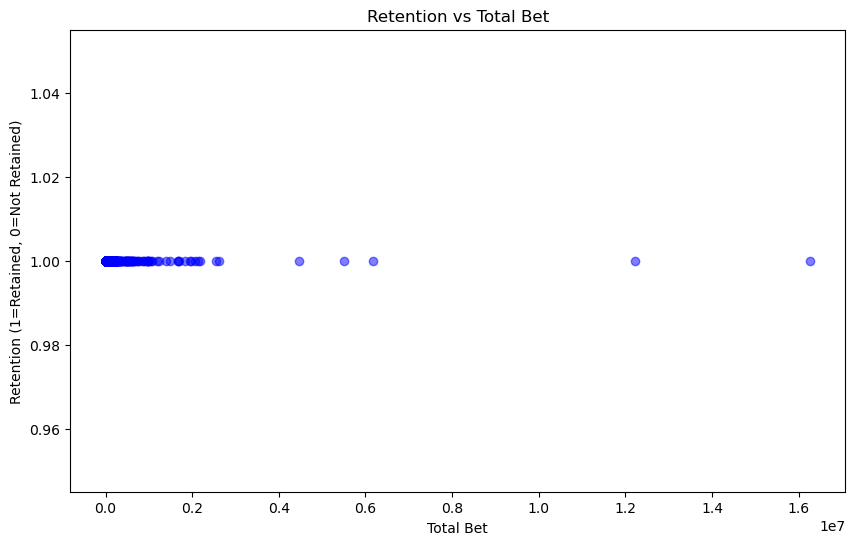

Correlation between Total Bet and Retention: nan


/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2897: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/opt/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:2898: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


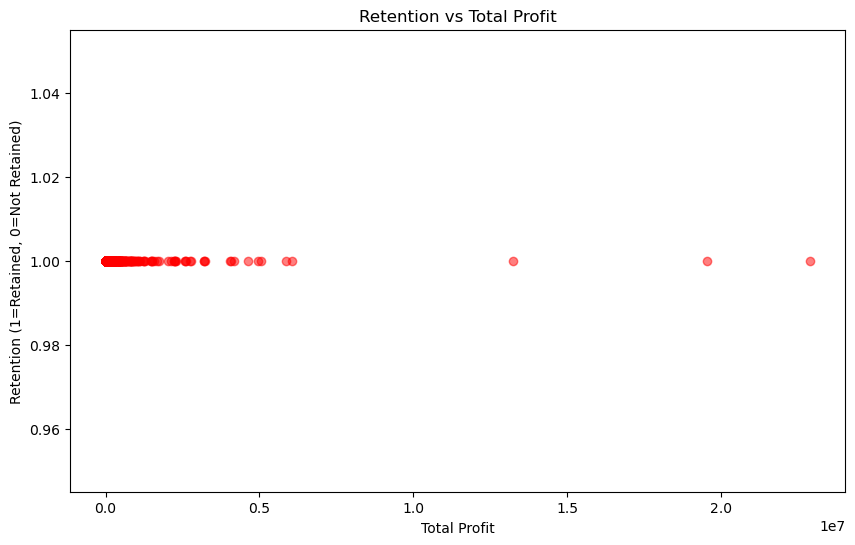

Correlation between Total Profit and Retention: nan


In [52]:
# retention vs activity
retention_vs_activity = df_cleaned.groupby('Username').agg(
    total_bet=('Bet', 'sum'),
    total_profit=('NetProfit', 'sum'),
    total_games=('GameID', 'count'),
    avg_bet=('Bet', 'mean'),
    avg_profit=('NetProfit', 'mean'),
    retained=('retained', 'max')
).reset_index()

# Plotting Retention vs Player Activity (e.g., Total Bet vs Retention)
plt.figure(figsize=(10, 6))
plt.scatter(retention_vs_activity['total_bet'], retention_vs_activity['retained'], alpha=0.5, color='blue')
plt.title('Retention vs Total Bet')
plt.xlabel('Total Bet')
plt.ylabel('Retention (1=Retained, 0=Not Retained)')
plt.show()

# Calculating the correlation between player activity and retention
correlation_bet_retention = retention_vs_activity['total_bet'].corr(retention_vs_activity['retained'])
print(f"Correlation between Total Bet and Retention: {correlation_bet_retention}")

# Similar analysis for Total Profit
plt.figure(figsize=(10, 6))
plt.scatter(retention_vs_activity['total_profit'], retention_vs_activity['retained'], alpha=0.5, color='red')
plt.title('Retention vs Total Profit')
plt.xlabel('Total Profit')
plt.ylabel('Retention (1=Retained, 0=Not Retained)')
plt.show()

correlation_profit_retention = retention_vs_activity['total_profit'].corr(retention_vs_activity['retained'])
print(f"Correlation between Total Profit and Retention: {correlation_profit_retention}")


In [2]:
#This report highlights the value of understanding player behavior and retention patterns for improving engagement, retention, and profitability on the Bustabit platform. By applying these insights, operators can create more targeted retention strategies and optimize user experience for different player segments.